# Topic Modeling the Dispatch — Part II


Here we need to reload necessary elements from Part I.

In [1]:
import re
import pandas

# Gensim
import gensim
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

from ast import literal_eval # for loading columns with lists

We need to ensure that data in the columns is in the formats that it must be for further processing: namely, we need to ensure that dates are in the date format (we did that before), but most importantly that our generated columns with *lists* of words are lists and not strings (that is how they will be loaded from a CSV file by default). The latter can be done during loading (`literal_eval`).

**Note:** we can actually reduce the size of the `Dispatch_Light_Preprocessed.tsv` by removing columns that we do not really need anymore: `textData` and `textDataLists` (we only need `textDataListsFiltered`).

The following should load preprocessed Dispatch data for 1860-1864. 

In [2]:
# WE CAN EDIT THIS LIST IN ORDER TO REDUCE THE AMOUNT OF DATA THAT WE ARE LOADING
dispatchSubfolder = "./Dispatch_Processed_TSV/"
dispatchFiles = ["Dispatch_1860_Light_Preprocessed.tsv",  # incomplete
                 "Dispatch_1861_Light_Preprocessed.tsv",  # The War starts of April 12, 1861
                 "Dispatch_1862_Light_Preprocessed.tsv",
                 "Dispatch_1863_Light_Preprocessed.tsv",
                 "Dispatch_1864_Light_Preprocessed.tsv",
                 #"Dispatch_1865_Light_Preprocessed.tsv",  # incomplete - The War ends on May 9, 1865
                 ]

df = pandas.DataFrame()

for f in dispatchFiles:
    dfTemp = pandas.read_csv(dispatchSubfolder + f, sep="\t", header=0, converters={'textDataListsFiltered': literal_eval})
    df = df.append(dfTemp)

dispatch_light = df
# drop=True -- use it to avoid creating a new column with the old index values
dispatch_light = dispatch_light.reset_index(drop=True) 

dispatch_light["month"] = pandas.to_datetime(dispatch_light["month"], format="%Y-%m")
dispatch_light["date"] = pandas.to_datetime(dispatch_light["date"], format="%Y-%m-%d")

In [3]:
dispatch_light

,id,month,date,type,header,text,textDataListsFiltered
0,1860-12-31_article_000,1860-12-01,1860-12-31,article,The National crisis.particulars of the evacuat...,The National crisis. particulars of the evacua...,"[national, crisis, particulars, evacuation, oc..."
1,1860-12-31_article_000,1860-12-01,1860-12-31,article,"[from the Charleston courier, of Friday.]Fort ...","[from the Charleston courier, of Friday.] Fort...","[charleston, courier, friday, fort, moultrie, ..."
2,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of Commodore Platt.,Death of Commodore Platt.;;; Another of our mo...,"[death, commodore, platt, eminent, public, ser..."
3,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of the last survivor of the battle of Bu...,Death of the last survivor of the battle of Bu...,"[death, survivor, battle, bunker, hill, ralph,..."
4,1860-12-31_article_000,1860-12-01,1860-12-31,article,Christmas in Charleston.,"Christmas in Charleston.;;; --It seemed, on Tu...","[christmas, charleston, seemed, elements, cons..."
...,...,...,...,...,...,...,...
97900,1864-03-31_article_000,1864-03-01,1864-03-31,article,Richmond &amp; Danville R R Supt's office. Ric...,Richmond &amp; Danville R R Supt's office. Ric...,"[richmond, amp, danville, supt, office, richmo..."
97901,1864-03-31_article_000,1864-03-01,1864-03-31,article,300 dollars reward.,"300 dollars reward.;;; --Stolen, in Richmond, ...","[dollars, reward, stolen, richmond, saturday, ..."
97902,1864-03-31_article_000,1864-03-01,1864-03-31,article,Two hundred dollars reward,Two hundred dollars reward;;; --Will be paid f...,"[hundred, dollars, reward, paid, apprehension,..."
97903,1864-03-31_article_000,1864-03-01,1864-03-31,article,Runaway,"Runaway;;; --From ""Our House,"" Saturday, 19th ...","[runaway, house, saturday, th, inst, black, se..."


# Create the Dictionary and Corpus Objects needed for Topic Modeling

In [5]:
%%time
# Create Dictionary
dictionary = gensim.corpora.Dictionary(dispatch_light["textDataListsFiltered"])

# Create Corpus
texts = dispatch_light["textDataListsFiltered"]

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts] # bow == bag of words

# View
print(corpus[:1])
print("-"*50)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 2), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 3), (46, 2), (47, 1), (48, 2), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 2), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1)]]
--------------------------------------------------
CPU times: user 7.59 s, sys: 213 ms, total: 7.8 s
Wall time: 7.9 s


This list above is a text: every tuple (like `(0, 1)`) represents a word (first number) and its frequency (second number). We can check which word is hiding behind a number by:

In [11]:
dictionary[45]

'president'

So, the word `president` occurs three times in the article. And this is the complete text hiding behinf this numeric abstraction:

In [13]:
dispatch_light["text"][0]

'The National crisis. particulars of the evacuation and occupation of Fort Moultrie. resignation of Secretary Floyd. &amp;c., &amp;c., &amp;c.;;; The Washington Constitution of yesterday announces that the resignation of Hon. John B. Floyd, Secretary of War, was tendered on Saturday, and accepted by the President.--The Star of the evening before, foreshadowing this result, says:;;; The on dit of the day, immediately around us is, that Secretaries Floyd, Thompson, and Thomas, all of whom believe in the alleged constitutional right of secession, it will be remembered, have formally notified the President that they will resign their respective portfolios unless he accede to the demand of the South Carolina Commissioners, that orders shall be issued to Major Anderson directing him to go back to Fort Moultrie from Fort Sumter, with all his force — of course thus shadowing the latter to the --This rumor is probably true.;;; we may not inappropriately add, that if such orders are issued to Ma

# Optimal Number of Topics

The number of topics is a tricky issue, since we pre-determine this number and the algorithm then splits all data into that number of topics. In other words, if you tell the machine to find 10 topics, it will use 10 buckets to sort all the data into; if you give it 20, it will do that for 20. For this reason topic modeling often takes multiple attempts. Additionally, it is not uncommon to then pull out a specific topic from your data and re-run the algorithm on that subset of texts. 

Nonetheless, there is a mathematical way to identify the optimal number of topics. The common practice is to generate several models and calculate `coherence score` (*k*) for them all—the number with the highest `coherence score` is considered optimal (ideally, above 0.55). 

**NB**: Do not run the code below during the class, as it took over 3 hours to complete (this time will differ significantly depending on the configuration of your machine).

**NB:** You can comment out the entire chunk by selecting it and pressing `Ctrl+/` on Windows or `Cmd+/` on Mac. Pressing these combinations again will make code runnable again.

In [14]:
# %%time

# for num in range(4, 36, 1):
#     lda_model_temp = gensim.models.LdaModel(corpus=corpus,id2word=dictionary,
#                                    num_topics=num, update_every=1, passes=1, alpha='auto')
#     coherence_model_lda = CoherenceModel(model=lda_model_temp,texts=dispatch_light["textDataListsFiltered"],
#                                      dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print('Coherence Score for %02d topics: ' % num, coherence_lda)
    
# print("-"*50)

Not really necessary, but we can plot these results in the following manner (score above 0.55 should be ok):

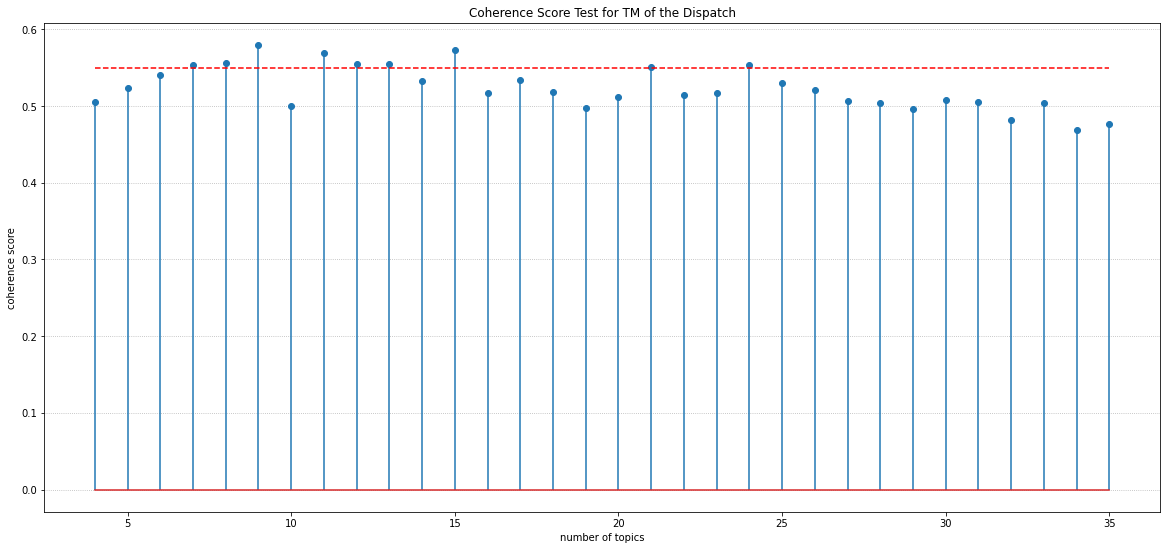

In [15]:
import io

scores = """topics	score	choice
04	0.5046743225586512	0
05	0.5230303503839578	0
06	0.5398320446007977	0
07	0.5533172859929912	0
08	0.5562409711643069	0
09	0.5796037356135678	1
10	0.4997342584472958	0
11	0.5688070886343136	1
12	0.5544838616000692	0
13	0.5547374234791211	0
14	0.5326402936709286	0
15	0.5730118928700542	1
16	0.5170284175516602	0
17	0.533200125371425	0
18	0.5185637000245759	0
19	0.4973878465206809	0
20	0.5118376251647202	0
21	0.5507626592415328	1
22	0.5147567145093666	0
23	0.5164742625875036	0
24	0.5527394408165394	1
25	0.5302590873311892	0
26	0.5205032365824975	0
27	0.5063682522167032	0
28	0.5040345440057103	0
29	0.4955523220443989	0
30	0.5074075365026981	0
31	0.5044936852566745	0
32	0.4820233615204512	0
33	0.5042828606887998	0
34	0.4683523982125954	0
35	0.4759028628877245	0
"""

scoresData = io.StringIO(scores)
scoresDF = pandas.read_csv(scoresData, sep="\t", header=0)

plt.rcParams["figure.figsize"] = (20, 9)
plt.stem(scoresDF['topics'], scoresDF['score'])
plt.plot([4, 35], [0.55, 0.55], color="red", linestyle="--")

plt.ylabel("coherence score")
plt.xlabel("number of topics")
plt.title("Coherence Score Test for TM of the Dispatch")
plt.gca().yaxis.grid(linestyle=':')

plt.show()

It looks like we have several "sweet spots" where the corpus breaks down into a coherent number of topics—essentially, all above 0.55, with the preference to: 9, 11, 15, 21, and 24. Personally, I would go with 24—since we have quite a lot of data, it is likely to be beneficial to have a higher number of topics. However, if you are doing an in-depth study of some corpus, it makes sense to generate models for all meaningful matches (in this case—7, 8, 9, 11, 12, 13, 15, 21, and 24). You are likely to observe that certain meaningful topics will appear at some point and will disappear when you increase or decrease the number of topics.

# Building the Topic Model

The following step usually takes quite a lot of time, so do not run it in class. You may want to leave it running overnight. Ideally, the number of passes should be at least a hundred—this increases the stability of topics, but also increases the amount of time required for generating the model. Good news is that you do not have to train the model every time: you can save it and load everytime you want to use it.

On all the data (and we have a very large corpus), with 100 passes and 20 updates:

```
CPU times: user 3h 30min 39s, sys: 1h 32min 40s, total: 5h 3min 20s
Wall time: 41min 20s
```

**NB:** You can comment out the entire chunk by selecting it and pressing `Ctrl+/` on Windows or `Cmd+/` on Mac. Pressing these combinations again will make code runnable again.

We can also train a quick and simple model with the default parameters of the training function (commented out: `#update_every=20, passes=100, alpha='auto',`). On my computer it took only about 4 mins, but it may take significantly longer depending on the configuration of your machine.

In [16]:
number_of_topics = 24

In [17]:
%%time
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   #update_every=20, passes=100, alpha='auto',
                                   num_topics=number_of_topics)

print("-"*50)

--------------------------------------------------
CPU times: user 4min 3s, sys: 2min, total: 6min 3s
Wall time: 50.1 s


These are just a couple of lines of code for saving your model; since we are not generating one, they are commented out.

In [18]:
# make sure to create this folder on your machine
path_to_models = "./Dispatch_Processed_TSV/models/" 
lda_model.save(path_to_models + "model_dispatch_1860_1864_%d_Light.lda" % number_of_topics)

These lines will load the pre-generated model:

In [19]:
#path_to_models = "./Dispatch_Processed_TSV/models/"
#lda_model = gensim.models.LdaModel.load(path_to_models + "model_dispatch_1860_1864_%d_Light.lda" % number_of_topics)

# View generated topics

In [20]:
# Print the Keyword in topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(1,
  '0.017*"enemy" + 0.016*"general" + 0.013*"gen" + 0.012*"army" + 0.007*"th" + '
  '0.007*"officers" + 0.006*"prisoners" + 0.006*"troops" + 0.006*"force" + '
  '0.006*"yankee"'),
 (23,
  '0.048*"notes" + 0.031*"hood" + 0.029*"currency" + 0.026*"tax" + '
  '0.025*"treasury" + 0.015*"banks" + 0.015*"loyal" + 0.014*"taxes" + '
  '0.013*"jan" + 0.011*"bank"'),
 (8,
  '0.069*"reward" + 0.045*"dollars" + 0.039*"feet" + 0.032*"negro" + '
  '0.029*"inches" + 0.027*"richmond" + 0.025*"black" + 0.022*"delivery" + '
  '0.021*"hundred" + 0.020*"paid"'),
 (0,
  '0.024*"cotton" + 0.019*"market" + 0.015*"gold" + 0.014*"london" + '
  '0.013*"french" + 0.011*"bushel" + 0.011*"corn" + 0.010*"prices" + '
  '0.009*"york" + 0.009*"flour"'),
 (7,
  '0.035*"co" + 0.030*"john" + 0.026*"wm" + 0.026*"mrs" + 0.023*"miss" + '
  '0.017*"va" + 0.015*"dr" + 0.015*"james" + 0.015*"smith" + 0.014*"mr"'),
 (20,
  '0.026*"court" + 0.020*"yesterday" + 0.018*"charged" + 0.017*"mayor" + '
  '0.014*"case" + 0.013*"arre

How can we infer topics?

# Visualize topic-keywords

`pyLDAvis` library offers a visual tool for exploring topics. **λ-parameter** is designed to "slice" topics words in such a way that topics would be easier to interpret. If you slide this parameter below 1, you will see that the selection of words changes and if you reach 0, only words unique to this topic will be shown.

**NB:** Keep in mind that on the visualization topics are numbered from 1, not from 0 as in the data!

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
modelVis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# you are likely to see lots of red-ish text --- just ignore it... 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationW

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Library/Frameworks/Python.framework

In [22]:
pyLDAvis.save_html(modelVis, 'TM_Vis_%02d_Topics_in_Dispatch_1860_1864_Light.html' % number_of_topics)
modelVis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.246263 -0.211514       1        1  24.344906
1      0.284247 -0.111701       2        1  22.857753
11     0.196901 -0.157377       3        1   8.801216
13     0.184547 -0.013588       4        1   5.501531
20     0.165892  0.062609       5        1   4.130893
17     0.067566  0.188670       6        1   3.787100
7     -0.027603  0.224019       7        1   3.237235
0      0.025354 -0.156162       8        1   2.600787
9      0.032640  0.065707       9        1   2.500220
12    -0.042150  0.106022      10        1   2.401275
3      0.019386  0.079092      11        1   2.392395
8     -0.006351  0.153517      12        1   2.255932
4      0.027993  0.149052      13        1   2.072388
5      0.018492  0.109782      14        1   2.017335
10    -0.159612 -0.102606      15        1   1.875736
22    -0.135449 -0.108244      16        1   1.722780
6      0.016439  0.074577      17        1   1.507685
15    -0.083276 -0.050300      18        1   1.330850
19    -0.068756  0.057170      19        1   1.182107
23    -0.015311 -0.005922      20        1   1.180351
16    -0.164552 -0.121287      21        1   0.876241
14    -0.195124 -0.107188      22        1   0.557272
2     -0.174448 -0.001903      23        1   0.538249
21    -0.213088 -0.122425      24        1   0.327763, topic_info=               Term          Freq         Total Category  logprob  loglift
1089             th  80199.000000  80199.000000  Default  30.0000  30.0000
576              mr  47384.000000  47384.000000  Default  29.0000  29.0000
243         company  20532.000000  20532.000000  Default  28.0000  28.0000
1818       richmond  39273.000000  39273.000000  Default  27.0000  27.0000
1817         reward  14749.000000  14749.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3325      entrusted    212.827622    512.550683  Topic24  -4.9890   4.8417
13644        boards    233.622205   1349.726844  Topic24  -4.8958   3.9667
2459   satisfactory    196.389193   1159.490037  Topic24  -5.0694   3.9450
3233           lady    206.401090   2926.350102  Topic24  -5.0197   3.0689
682          public    179.307676  13914.942449  Topic24  -5.1604   1.3690

[1725 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
12603     14  0.994025  abilities
77         1  0.520144       able
77         2  0.229555       able
77         3  0.009542       able
77         4  0.000180       able
...      ...       ...        ...
903       22  0.000128       york
7297      10  0.003285   youngest
7297      13  0.995432   youngest
12606     14  0.999225      youth
10636     23  0.995555     youths

[6772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 2, 12, 14, 21, 18, 8, 1, 10, 13, 4, 9, 5, 6, 11, 23, 7, 16, 20, 24, 17, 15, 3, 22])

# Let's explore our topics more

In [23]:
dispatch_light.head()

,id,month,date,type,header,text,textDataListsFiltered
0,1860-12-31_article_000,1860-12-01,1860-12-31,article,The National crisis.particulars of the evacuat...,The National crisis. particulars of the evacua...,"[national, crisis, particulars, evacuation, oc..."
1,1860-12-31_article_000,1860-12-01,1860-12-31,article,"[from the Charleston courier, of Friday.]Fort ...","[from the Charleston courier, of Friday.] Fort...","[charleston, courier, friday, fort, moultrie, ..."
2,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of Commodore Platt.,Death of Commodore Platt.;;; Another of our mo...,"[death, commodore, platt, eminent, public, ser..."
3,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of the last survivor of the battle of Bu...,Death of the last survivor of the battle of Bu...,"[death, survivor, battle, bunker, hill, ralph,..."
4,1860-12-31_article_000,1860-12-01,1860-12-31,article,Christmas in Charleston.,"Christmas in Charleston.;;; --It seemed, on Tu...","[christmas, charleston, seemed, elements, cons..."


## `get_document_topics` for the entire corpus

You can get `doc_topics`, `word_topics` and `phi_values` (probabilities of words for topics) for all the documents in the corpus in the following manner:

In [24]:
%%time
all_topics = lda_model.get_document_topics(corpus, per_word_topics=True)
print("-"*50)

--------------------------------------------------
CPU times: user 570 µs, sys: 5.25 ms, total: 5.82 ms
Wall time: 9.6 ms


Let's print out data for the first document:

In [25]:
%%time

for doc_topics, word_topics, phi_values in all_topics[:1]:
    print('New Document')
    print('\nDocument topics:', doc_topics)
    print('\nWord topics:', word_topics)
    print('\nPhi values:', phi_values)
    #print(" ")
    print('-------------- \n')

print("-"*50)

New Document

Document topics: [(1, 0.7715386), (7, 0.083605476), (18, 0.13490012)]

Word topics: [(0, [1, 18]), (1, [1, 18]), (2, [18, 1, 7]), (3, [1, 18]), (4, [1, 18]), (5, [7, 1, 18]), (6, [7, 1]), (7, [1]), (8, [1, 18]), (9, [1, 18]), (10, [1, 18]), (11, [1, 7, 18]), (12, [1, 18, 7]), (13, [1, 18]), (14, [18, 1]), (15, [18, 1]), (16, [1, 18]), (17, [18, 1]), (18, [1, 18]), (19, [1]), (20, []), (21, [1]), (22, [1]), (23, [1]), (24, [1, 18]), (25, [1]), (26, [1, 18]), (27, [1]), (28, [7, 1]), (29, [1, 7, 18]), (30, [1, 18]), (31, []), (32, [1, 18]), (33, [7, 1]), (34, [1, 18]), (35, [1, 18]), (36, [1, 7]), (37, [1]), (38, [18, 1]), (39, [1, 18]), (40, [1]), (41, [1, 18]), (42, [1]), (43, [1]), (44, []), (45, [1, 18, 7]), (46, [1, 18]), (47, [1, 18]), (48, [1, 18]), (49, [1, 18]), (50, [1, 18]), (51, [1, 18]), (52, [1]), (53, [1]), (54, [1, 18]), (55, [1, 18]), (56, [1, 7, 18]), (57, []), (58, [1, 18]), (59, [1, 18]), (60, [1, 18]), (61, [1]), (62, [1, 18]), (63, [7, 1]), (64, [7, 1]

Let's build a dataframe with topic values for every item (article) from the Dispatch. This will allow us to do more interesting things.

In [26]:
%%time

topicTableCols = [] # empty table for topic values (technically, a list still)
topicDic = {} # a dictionary with top words per topic

for i in range(0, number_of_topics, 1):
    tVal = "T%02d" % (i + 1)
    topicTableCols.append(tVal)
    
    topicVals  = lda_model.show_topic(i)
    topicWords = ", ".join([word for word, prob in topicVals])
    topicDic[tVal] = topicWords


CPU times: user 59.8 ms, sys: 33.6 ms, total: 93.4 ms
Wall time: 110 ms


In [27]:
pprint(topicDic)

{'T01': 'cotton, market, gold, london, french, bushel, corn, prices, york, '
        'flour',
 'T02': 'enemy, general, gen, army, th, officers, prisoners, troops, force, '
        'yankee',
 'T03': 'mh, meade, department, headq, jeff, notices, kemper, absentees, '
        'ordnance, richmond',
 'T04': 'bonds, treasury, richmond, virginia, state, secretary, department, '
        'certificates, cent, governor',
 'T05': 'th, clock, residence, friends, funeral, died, family, attend, aged, '
        'inst',
 'T06': 'court, sale, property, county, amp, district, th, farm, auction, sold',
 'T07': 'county, counties, corpus, habeas, capturing, writ, lt, driving, '
        'exchanged, rappahannock',
 'T08': 'co, john, wm, mrs, miss, va, dr, james, smith, mr',
 'T09': 'reward, dollars, feet, negro, inches, richmond, black, delivery, '
        'hundred, paid',
 'T10': 'river, petersburg, steamer, york, city, board, boat, vessels, point, '
        'ship',
 'T11': 'amp, sale, pound, fine, thy, pound

The following step may take a couple minutes.

- Here were creating an empty row (filled with zeros) for each document in our corpus;
- then we loop through all topic values for every given document;
- and feed existing values into our row with zeros (if we have a value, it will replace a zero);
- you can insert `print`/`input` statements in the code below to see the steps of the process.

The following piece of code takes quite a while, so do not run it in class:

```
--------------------------------------------------
CPU times: user 18min 41s, sys: 25min 56s, total: 44min 38s
Wall time: 6min 58s
```

In [28]:
%%time

topicTableRows = [] # now we are feeding topic values into our empty table

for doc_topics, word_topics, phi_values in all_topics:
    rawRow = [0] * number_of_topics
    for t in doc_topics:
        rawRow[t[0]] = t[1]
    topicTableRows.append(rawRow)

print("-"*50)

--------------------------------------------------
CPU times: user 18min 41s, sys: 25min 56s, total: 44min 38s
Wall time: 6min 58s


In [32]:
# different topics in the 0th document/article
topicTableRows[0]

[0,
 0.77156717,
 0,
 0,
 0,
 0,
 0,
 0.08360374,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.13487335,
 0,
 0,
 0,
 0,
 0]

So, our corpus table length:

In [33]:
len(dispatch_light)

97905

And our topic table length:

In [34]:
len(topicTableRows)

97905

We just need to convert it into a proper dataframe format:

In [35]:
topicTable = pandas.DataFrame(topicTableRows, columns=topicTableCols)
topicTable

,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,...,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24
0,0.0,0.771567,0.000000,0.000000,0.000000,0.000000,0.000000,0.083604,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.134873,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.636801,0.000000,0.000000,0.000000,0.011759,0.000000,0.000000,0.000000,0.018367,...,0.000000,0.000000,0.000000,0.022745,0.157571,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.282760,0.000000,0.000000,0.021123,0.000000,0.000000,0.000000,0.000000,0.132738,...,0.000000,0.000000,0.000000,0.021818,0.037606,0.0,0.077560,0.0,0.000000,0.016276
3,0.0,0.404931,0.000000,0.000000,0.068668,0.020655,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.193951,0.0,0.060960,0.0,0.000000,0.016556
4,0.0,0.000000,0.000000,0.000000,0.014988,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.159341,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97900,0.0,0.000000,0.028728,0.095728,0.000000,0.060443,0.038883,0.000000,0.372564,0.136690,...,0.000000,0.048202,0.103992,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
97901,0.0,0.158382,0.043458,0.000000,0.000000,0.000000,0.000000,0.000000,0.387038,0.000000,...,0.041908,0.000000,0.044553,0.085470,0.000000,0.0,0.081277,0.0,0.000000,0.000000
97902,0.0,0.033761,0.031954,0.000000,0.000000,0.000000,0.000000,0.066099,0.589502,0.000000,...,0.000000,0.000000,0.031741,0.000000,0.000000,0.0,0.000000,0.0,0.033082,0.000000
97903,0.0,0.000000,0.107785,0.000000,0.000000,0.000000,0.000000,0.000000,0.246087,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.071204,0.0,0.387014,0.0,0.000000,0.000000


While our topic table has the same dimensions (number of rows) as our Dispatch data, the rows in the topic table are indexed differently (starting from 0, while the Dispatch data starts from 1). We need to fix that before we can join topics table to the Dispatch data. Since default count in Python is from 0, it is easier to reset the Dispatch data like this:

In [36]:
dispatch_light = dispatch_light.reset_index(drop=True)
dispatch_light

,id,month,date,type,header,text,textDataListsFiltered
0,1860-12-31_article_000,1860-12-01,1860-12-31,article,The National crisis.particulars of the evacuat...,The National crisis. particulars of the evacua...,"[national, crisis, particulars, evacuation, oc..."
1,1860-12-31_article_000,1860-12-01,1860-12-31,article,"[from the Charleston courier, of Friday.]Fort ...","[from the Charleston courier, of Friday.] Fort...","[charleston, courier, friday, fort, moultrie, ..."
2,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of Commodore Platt.,Death of Commodore Platt.;;; Another of our mo...,"[death, commodore, platt, eminent, public, ser..."
3,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of the last survivor of the battle of Bu...,Death of the last survivor of the battle of Bu...,"[death, survivor, battle, bunker, hill, ralph,..."
4,1860-12-31_article_000,1860-12-01,1860-12-31,article,Christmas in Charleston.,"Christmas in Charleston.;;; --It seemed, on Tu...","[christmas, charleston, seemed, elements, cons..."
...,...,...,...,...,...,...,...
97900,1864-03-31_article_000,1864-03-01,1864-03-31,article,Richmond &amp; Danville R R Supt's office. Ric...,Richmond &amp; Danville R R Supt's office. Ric...,"[richmond, amp, danville, supt, office, richmo..."
97901,1864-03-31_article_000,1864-03-01,1864-03-31,article,300 dollars reward.,"300 dollars reward.;;; --Stolen, in Richmond, ...","[dollars, reward, stolen, richmond, saturday, ..."
97902,1864-03-31_article_000,1864-03-01,1864-03-31,article,Two hundred dollars reward,Two hundred dollars reward;;; --Will be paid f...,"[hundred, dollars, reward, paid, apprehension,..."
97903,1864-03-31_article_000,1864-03-01,1864-03-31,article,Runaway,"Runaway;;; --From ""Our House,"" Saturday, 19th ...","[runaway, house, saturday, th, inst, black, se..."


Now, we can merge them without any issues:

In [37]:
mergedTable = pandas.concat([dispatch_light, topicTable], axis=1, sort=False)
len(mergedTable)

97905

In [38]:
mergedTable

,id,month,date,type,header,text,textDataListsFiltered,T01,T02,T03,...,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24
0,1860-12-31_article_000,1860-12-01,1860-12-31,article,The National crisis.particulars of the evacuat...,The National crisis. particulars of the evacua...,"[national, crisis, particulars, evacuation, oc...",0.0,0.771567,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.134873,0.0,0.000000,0.0,0.000000,0.000000
1,1860-12-31_article_000,1860-12-01,1860-12-31,article,"[from the Charleston courier, of Friday.]Fort ...","[from the Charleston courier, of Friday.] Fort...","[charleston, courier, friday, fort, moultrie, ...",0.0,0.636801,0.000000,...,0.000000,0.000000,0.000000,0.022745,0.157571,0.0,0.000000,0.0,0.000000,0.000000
2,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of Commodore Platt.,Death of Commodore Platt.;;; Another of our mo...,"[death, commodore, platt, eminent, public, ser...",0.0,0.282760,0.000000,...,0.000000,0.000000,0.000000,0.021818,0.037606,0.0,0.077560,0.0,0.000000,0.016276
3,1860-12-31_article_000,1860-12-01,1860-12-31,article,Death of the last survivor of the battle of Bu...,Death of the last survivor of the battle of Bu...,"[death, survivor, battle, bunker, hill, ralph,...",0.0,0.404931,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.193951,0.0,0.060960,0.0,0.000000,0.016556
4,1860-12-31_article_000,1860-12-01,1860-12-31,article,Christmas in Charleston.,"Christmas in Charleston.;;; --It seemed, on Tu...","[christmas, charleston, seemed, elements, cons...",0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.159341,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97900,1864-03-31_article_000,1864-03-01,1864-03-31,article,Richmond &amp; Danville R R Supt's office. Ric...,Richmond &amp; Danville R R Supt's office. Ric...,"[richmond, amp, danville, supt, office, richmo...",0.0,0.000000,0.028728,...,0.000000,0.048202,0.103992,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
97901,1864-03-31_article_000,1864-03-01,1864-03-31,article,300 dollars reward.,"300 dollars reward.;;; --Stolen, in Richmond, ...","[dollars, reward, stolen, richmond, saturday, ...",0.0,0.158382,0.043458,...,0.041908,0.000000,0.044553,0.085470,0.000000,0.0,0.081277,0.0,0.000000,0.000000
97902,1864-03-31_article_000,1864-03-01,1864-03-31,article,Two hundred dollars reward,Two hundred dollars reward;;; --Will be paid f...,"[hundred, dollars, reward, paid, apprehension,...",0.0,0.033761,0.031954,...,0.000000,0.000000,0.031741,0.000000,0.000000,0.0,0.000000,0.0,0.033082,0.000000
97903,1864-03-31_article_000,1864-03-01,1864-03-31,article,Runaway,"Runaway;;; --From ""Our House,"" Saturday, 19th ...","[runaway, house, saturday, th, inst, black, se...",0.0,0.000000,0.107785,...,0.000000,0.000000,0.000000,0.000000,0.071204,0.0,0.387014,0.0,0.000000,0.000000


In [39]:
mergedTable.loc[[3947]]

,id,month,date,type,header,text,textDataListsFiltered,T01,T02,T03,...,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24
3947,1860-11-20_advert_000,1860-11-01,1860-11-20,advert,Just received.,Just received.;;; We have just received our se...,"[supply, fall, winter, stock, consisting, sele...",0.0,0.0,0.034518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815856,0.0


In [40]:
pprint(mergedTable["text"][3947])

('Just received.;;; We have just received our second supply of Fall and Winter '
 "stock, consisting of a large and well selected assortment of Ladies' Gent's, "
 "Misses ' and Children's Boots, Shoes, Gaiters, &amp;c., which we are "
 'prepared to sell as low as any house in the city, at wholesale or retail.;;; '
 'A call is respectfully solicited.;;; H. Stern &amp; Bro.,;;; oc 17 --1m No. '
 '87 Main st.')


# Graphing topics over time

One of the most interesting things that we can do with data like ours is to check how topics are distributed over time. Our data is already prepared for this, we only need to summarize topics values by days or months before we can graph them (for more [details](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)). `pandas` library has all we need, but there many specialized graphing libraries that may produce better visual results. (For more details, check this [overview](https://www.shanelynn.ie/plotting-with-python-and-pandas-libraries-for-data-visualisation/))

In [86]:
topicSum = mergedTable.groupby("month").mean().copy() # This will find the average mean for each topic for each month
topicSum["month"] = topicSum.index
topicSum.head()

,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,...,T16,T17,T18,T19,T20,T21,T22,T23,T24,month
month,,,,,,,,,,,,,,,,,,,,,
1860-11-01,0.029020,0.033996,0.013567,0.032619,0.032013,0.052858,0.017908,0.046845,0.020262,0.044352,...,0.028960,0.022025,0.035556,0.068102,0.020867,0.023205,0.012808,0.105541,0.014631,1860-11-01
1860-12-01,0.035983,0.050055,0.008786,0.033508,0.028812,0.049309,0.020034,0.047868,0.020842,0.043699,...,0.027035,0.015526,0.039941,0.105438,0.024428,0.040299,0.010242,0.072939,0.014370,1860-12-01
1861-01-01,0.031375,0.087661,0.006689,0.026128,0.023990,0.027418,0.018508,0.057902,0.016243,0.031037,...,0.030422,0.005973,0.047896,0.143935,0.025782,0.034424,0.005443,0.031437,0.018953,1861-01-01
1861-02-01,0.032580,0.063547,0.007280,0.027983,0.031153,0.033837,0.016179,0.056991,0.012088,0.034973,...,0.024787,0.010993,0.048739,0.124345,0.015303,0.034440,0.004864,0.060007,0.012415,1861-02-01
1861-03-01,0.041919,0.114482,0.012854,0.027107,0.027899,0.031383,0.016595,0.045146,0.022185,0.046527,...,0.020481,0.007353,0.046508,0.181097,0.015293,0.048940,0.003371,0.020512,0.011783,1861-03-01


Now we can plot all our topics and see their progression over time:

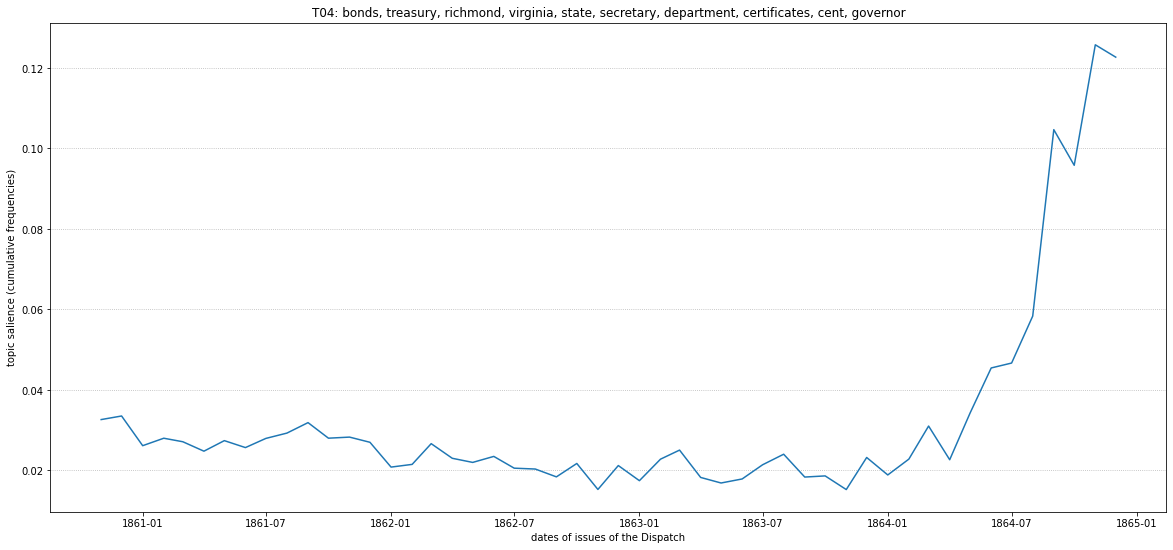

In [87]:
topic = "T04"

plt.rcParams["figure.figsize"] = (20, 9)
plt.plot(topicSum['month'], topicSum[topic])

plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

You can run the cell below to print out items most representative of this topic.

In [88]:
temp = mergedTable[mergedTable[topic] > 0.95].sort_values(by=topic, ascending=False)
temp[["id", "date", "text", topic]].head(15)

,id,date,text,T04
1518,1860-11-13_advert_000,1860-11-13,"Office of R. H. Maury &amp;CO Richmond, August...",0.970953
21755,1861-03-11_article_000,1861-03-11,"Office of R. H. Maury &amp; Co., Richmond, Aug...",0.970049
10344,1860-11-30_advert_000,1860-11-30,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.969083
6837,1860-11-19_advert_000,1860-11-19,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.968053
12524,1860-11-16_advert_000,1860-11-16,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.968053
13814,1860-12-06_advert_000,1860-12-06,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.968053
9554,1860-11-02_advert_000,1860-11-02,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.968053
8962,1860-11-05_advert_000,1860-11-05,"Office of R. R. Maury &amp; Co Richmond, Augus...",0.968053
8497,1860-11-03_advert_000,1860-11-03,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.968053
13043,1860-11-29_advert_000,1860-11-29,"Office of R. H. Maury &amp; Co Richmond, Augus...",0.968053


And you can check individual items like this:

In [89]:
pprint(mergedTable["text"][1518])

('Office of R. H. Maury &amp;CO Richmond, August 29, 1860.;;; Stocks and Bonds '
 'for sale.-- Virginia six per cents.;;; Orange and Alexandria Railroad six '
 "per cents.;;; Shares Bank of Commonwealth Stock.;;; Shares Farmers ' Bank "
 'Stock.;;; Shares Bank of Virginia Stock. au 25 --ts;;; Railroads, '
 'Steamboats, &amp;c.')


We can also use `plotly` library to generat dynamic graphs:

In [90]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [91]:
# Create the data for the bar chart
bar_data = go.Bar(
    x=topicSum["month"], 
    y=topicSum[topic]
)
# Create the layout information for display
layout = go.Layout(
    title=topic+": "+topicDic[topic],    
    xaxis=dict(title='Dates'),
    yaxis=dict(title='Topic Salience')
)
# These two together create the "figure"
figure = go.Figure(data=[bar_data], layout=layout)
# Use "iplot" to create the figure in the Jupyter notebook
iplot(figure)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



`Plotly` also allows one to save a graph into a separate file for sharing and embedding:

In [92]:
plot(figure, filename="dispatch_1860_1864_%s.html" % topic)

'dispatch_1860_1864_T04.html'

# Plots of all topics

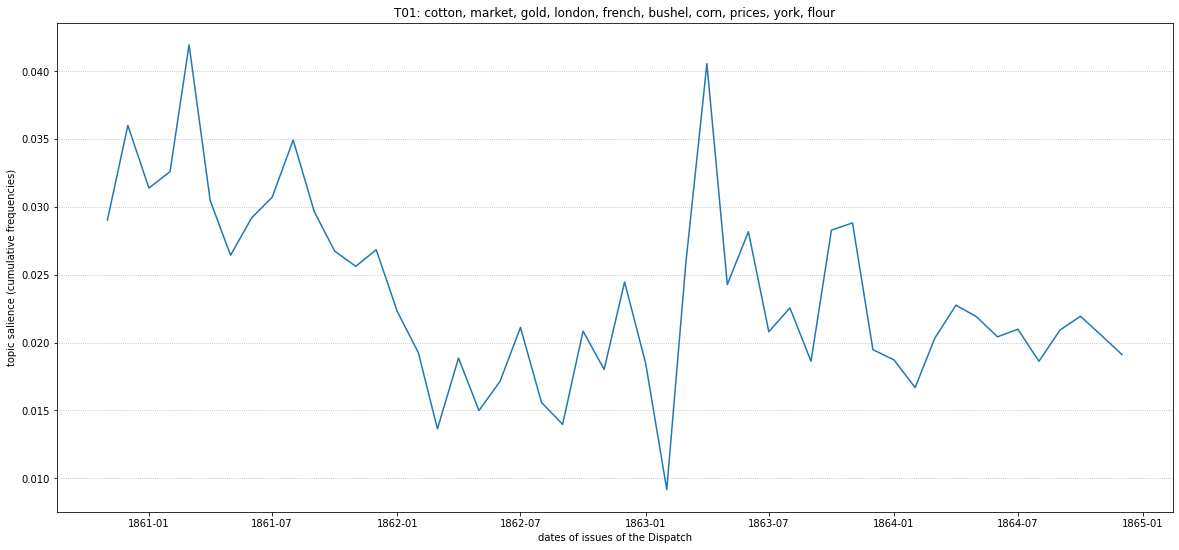

In [93]:
topic = "T01"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

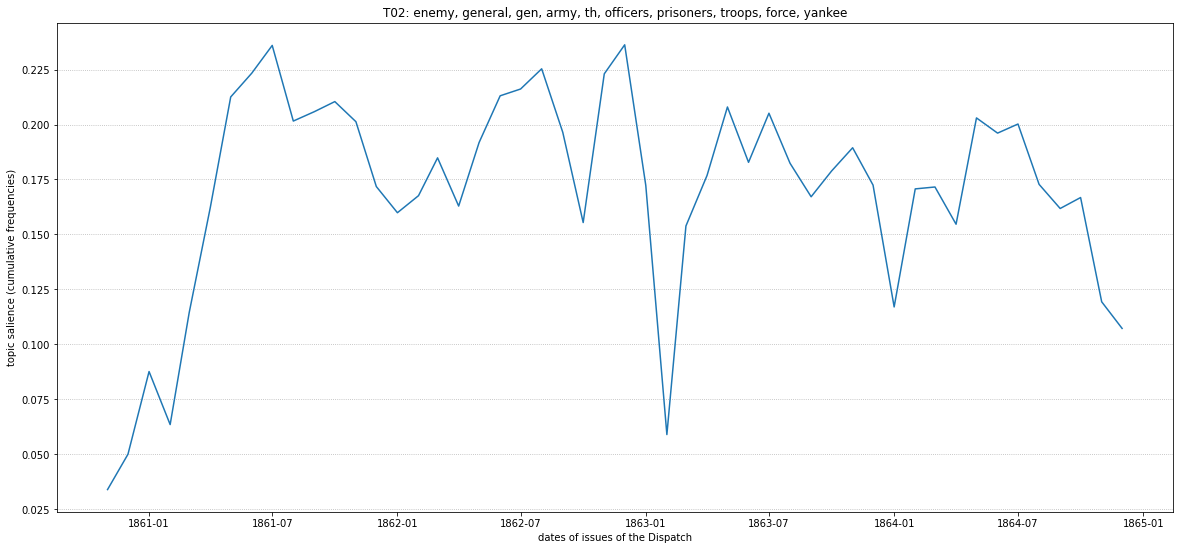

In [94]:
topic = "T02"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

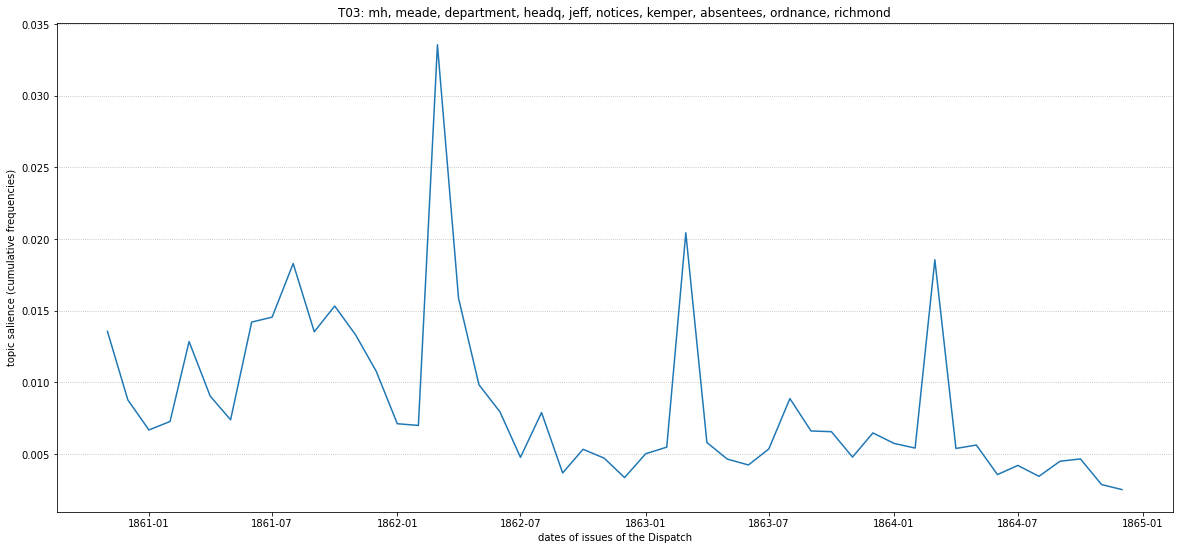

In [95]:
topic = "T03"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

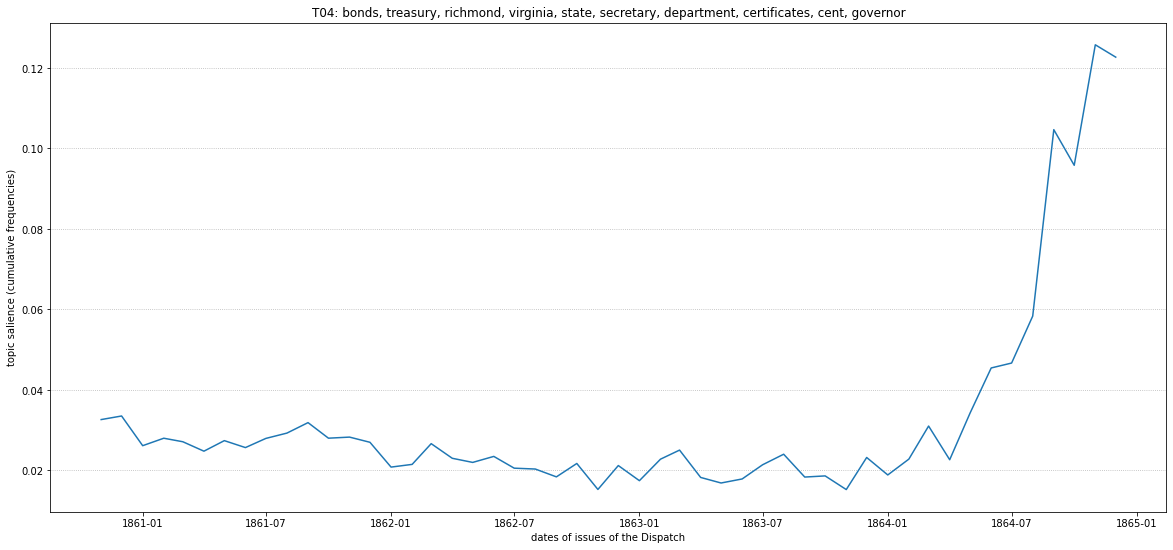

In [96]:
topic = "T04"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

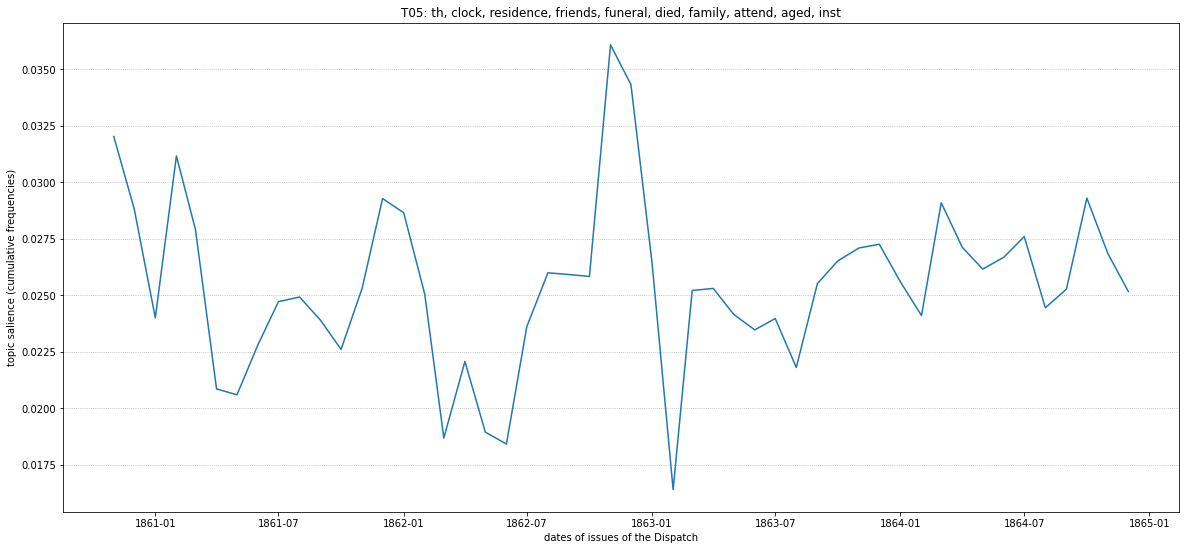

In [97]:
topic = "T05"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

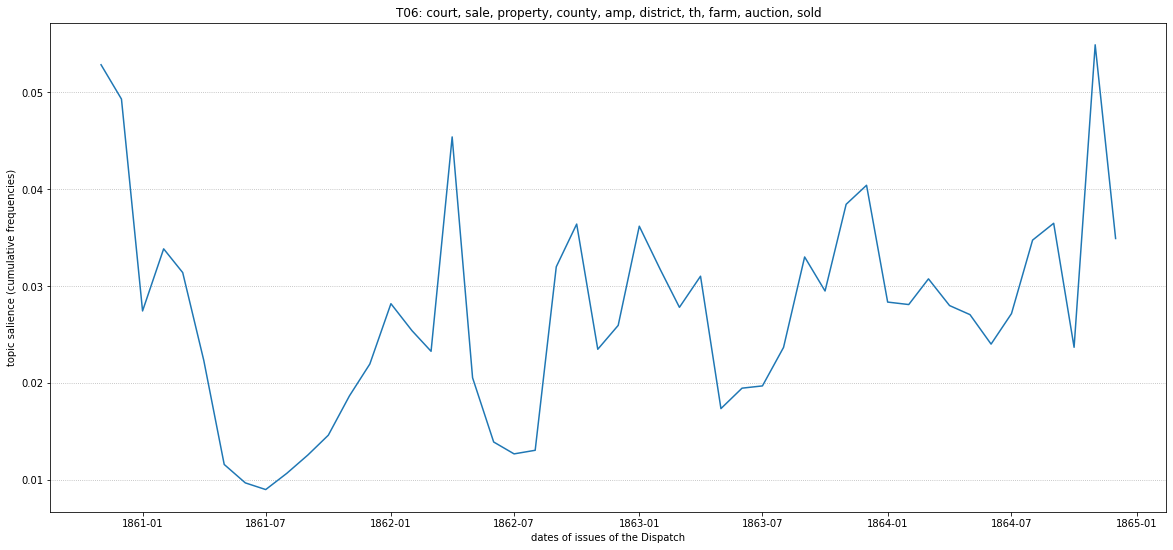

In [98]:
topic = "T06"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

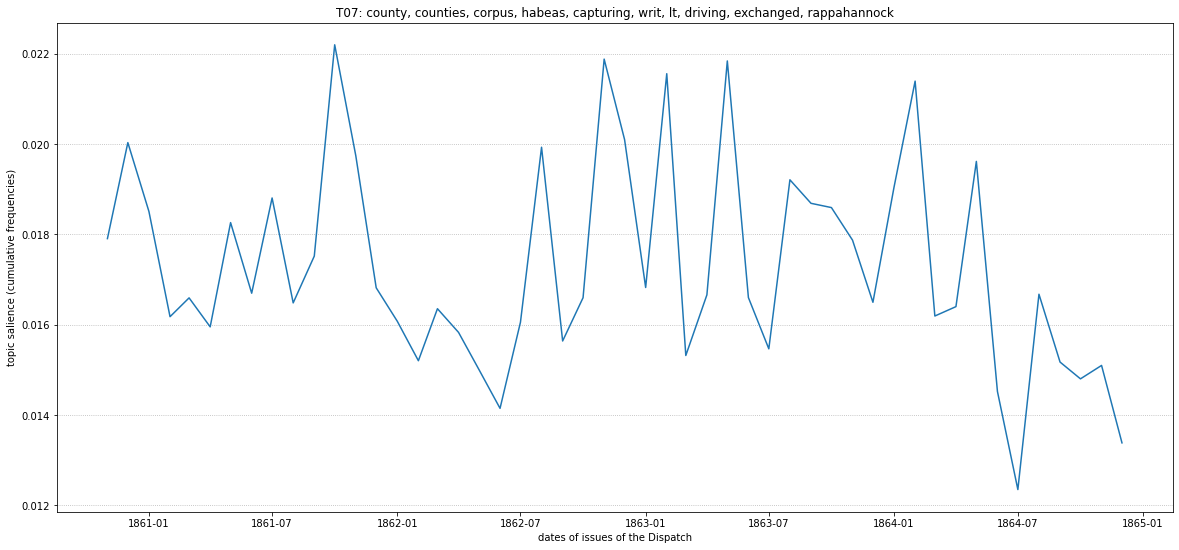

In [99]:
topic = "T07"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

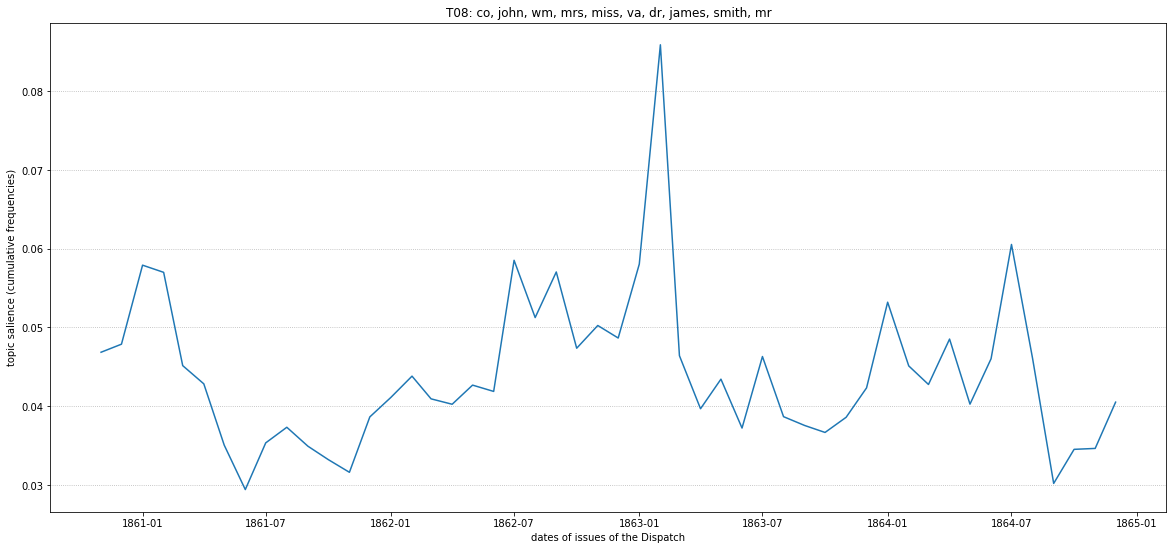

In [100]:
topic = "T08"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

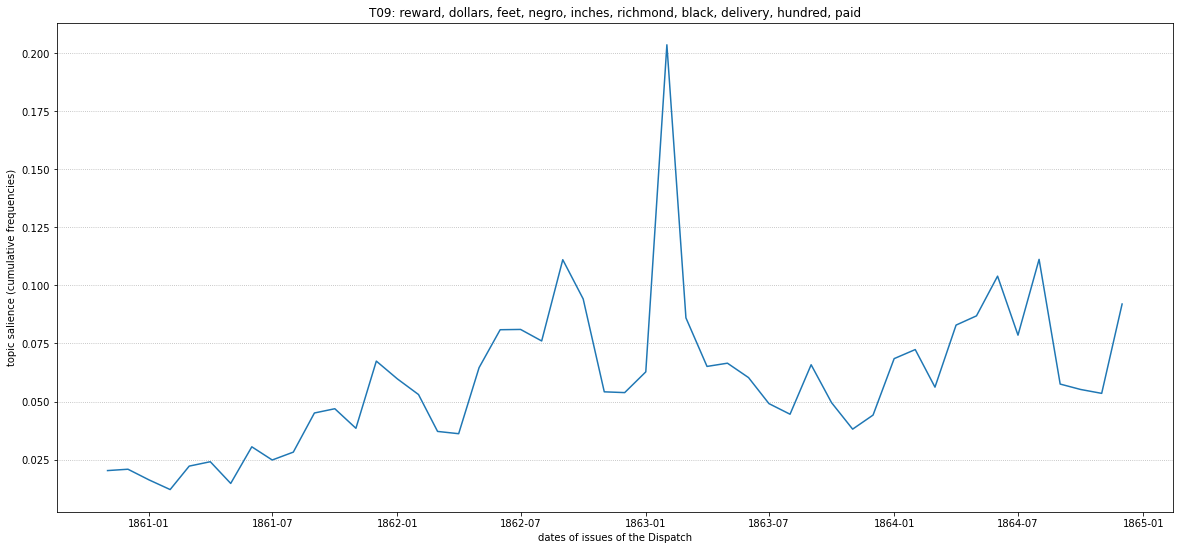

In [101]:
topic = "T09"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

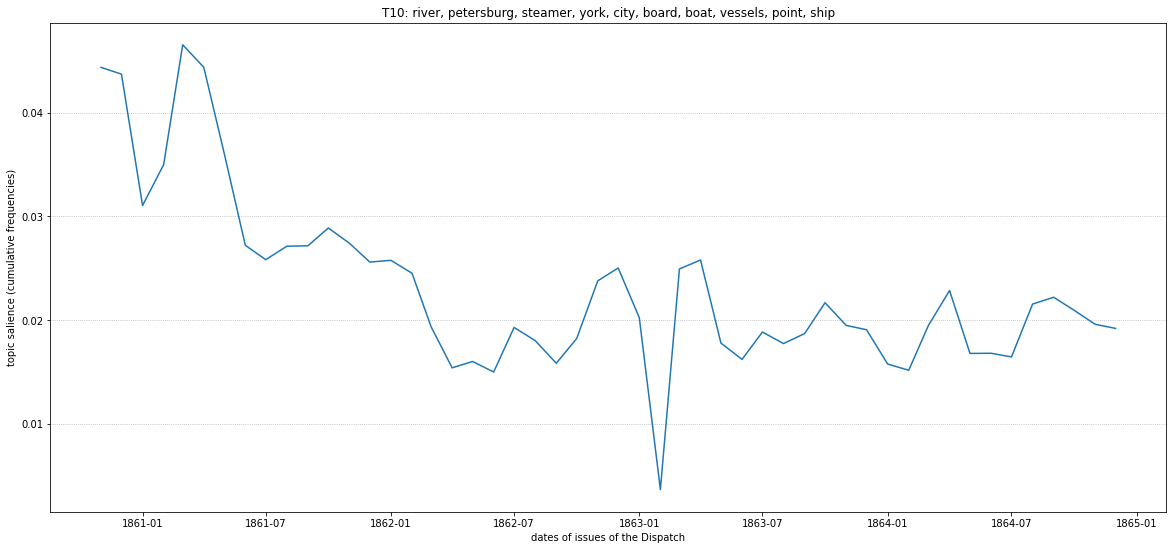

In [102]:
topic = "T10"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

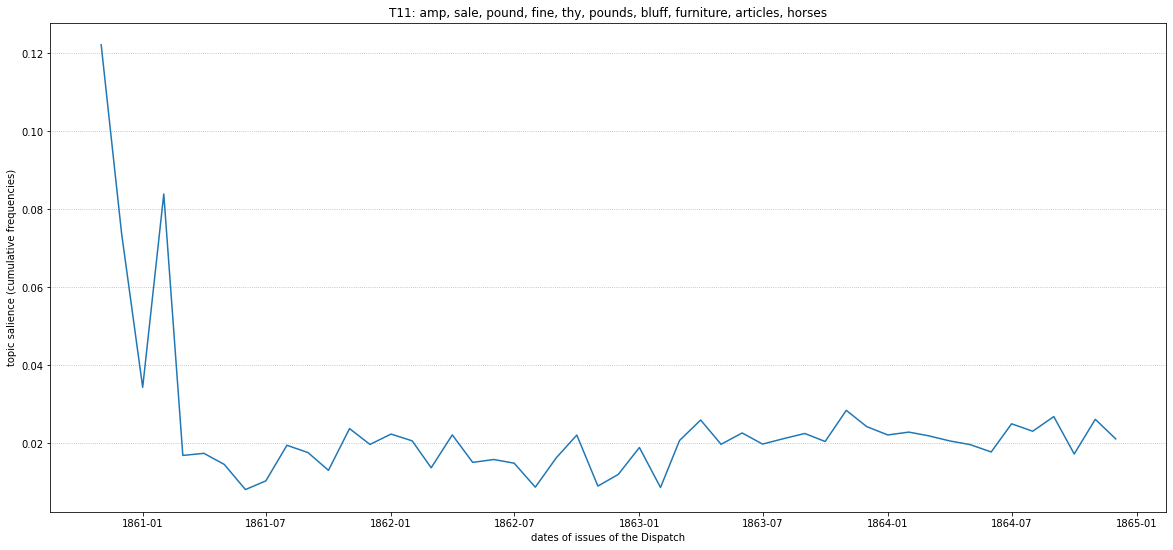

In [103]:
topic = "T11"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

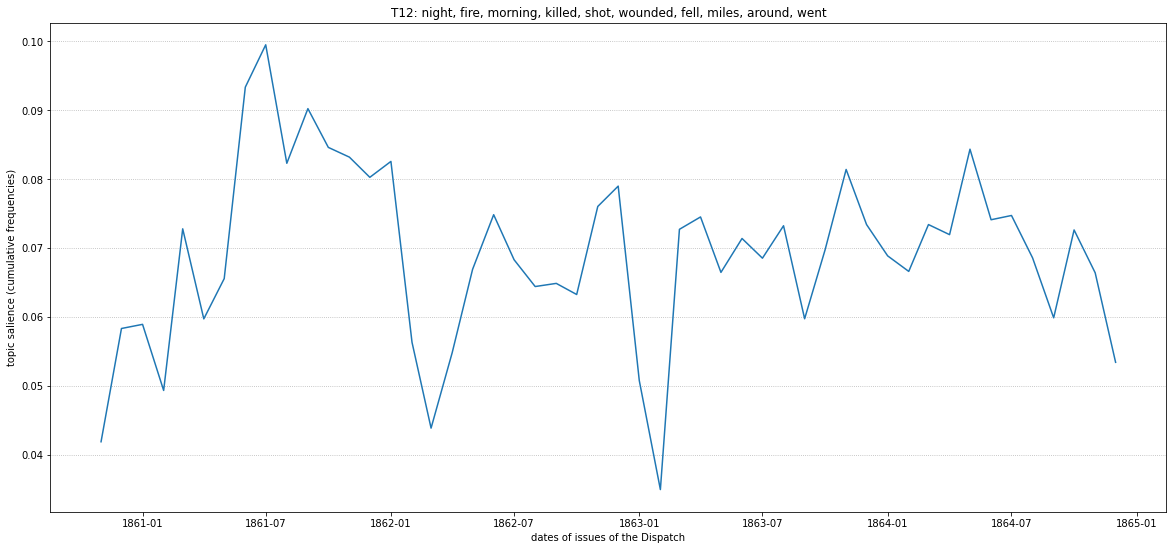

In [104]:
topic = "T12"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

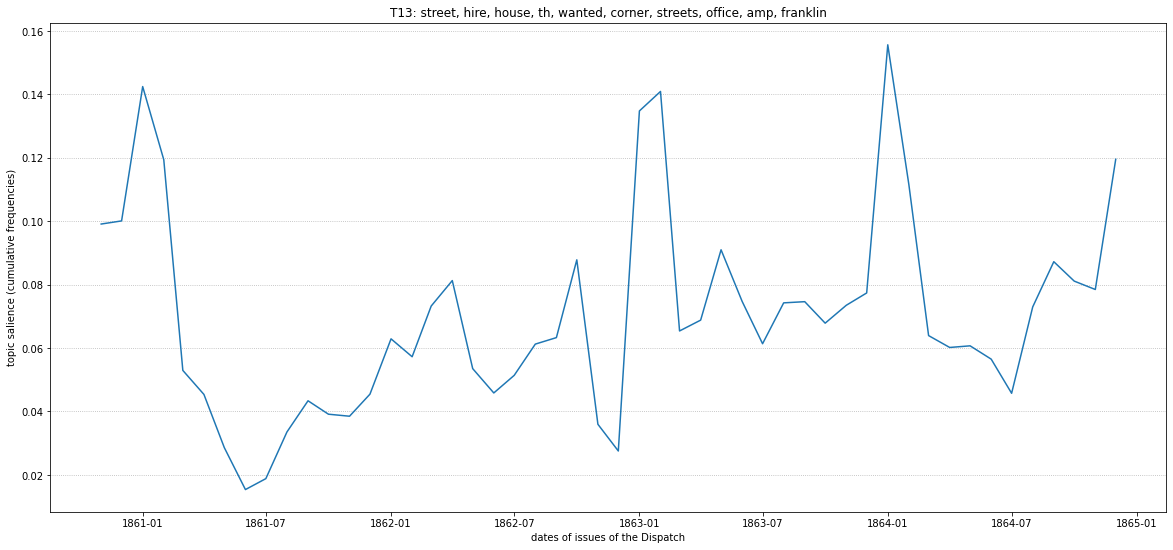

In [105]:
topic = "T13"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

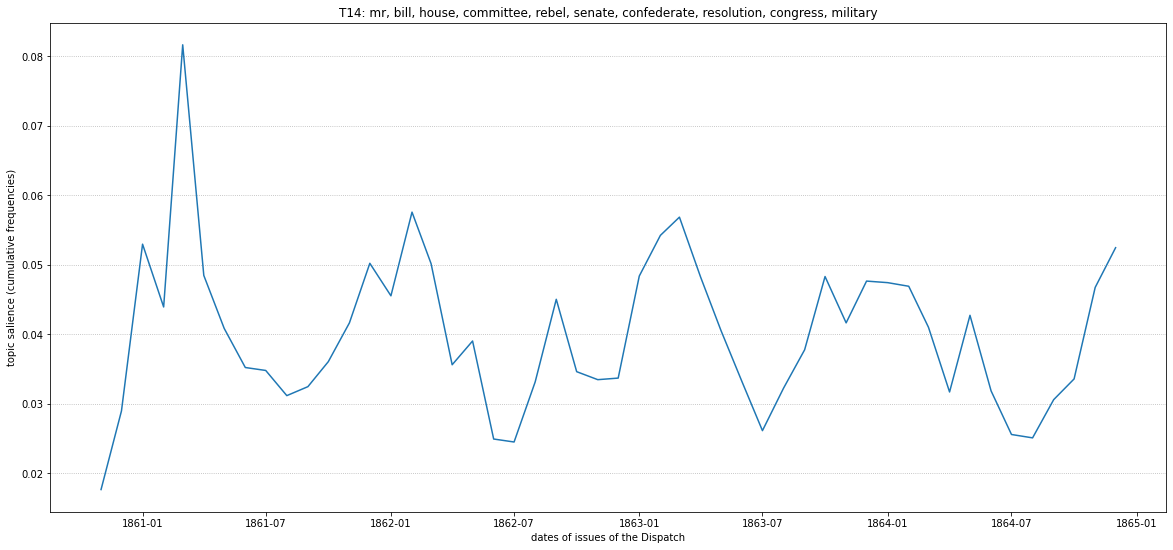

In [106]:
topic = "T14"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

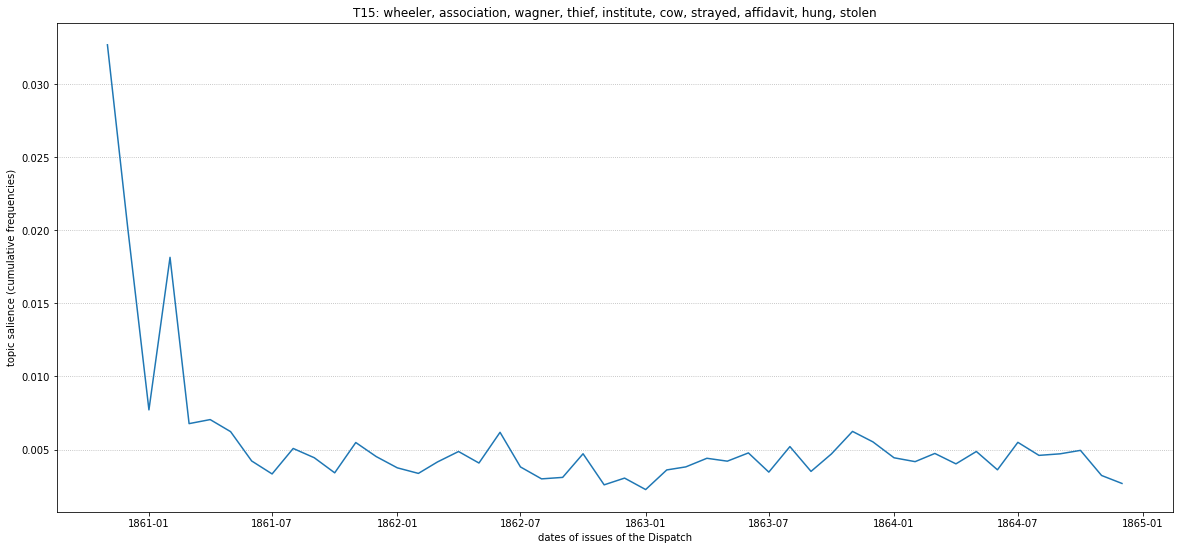

In [107]:
topic = "T15"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

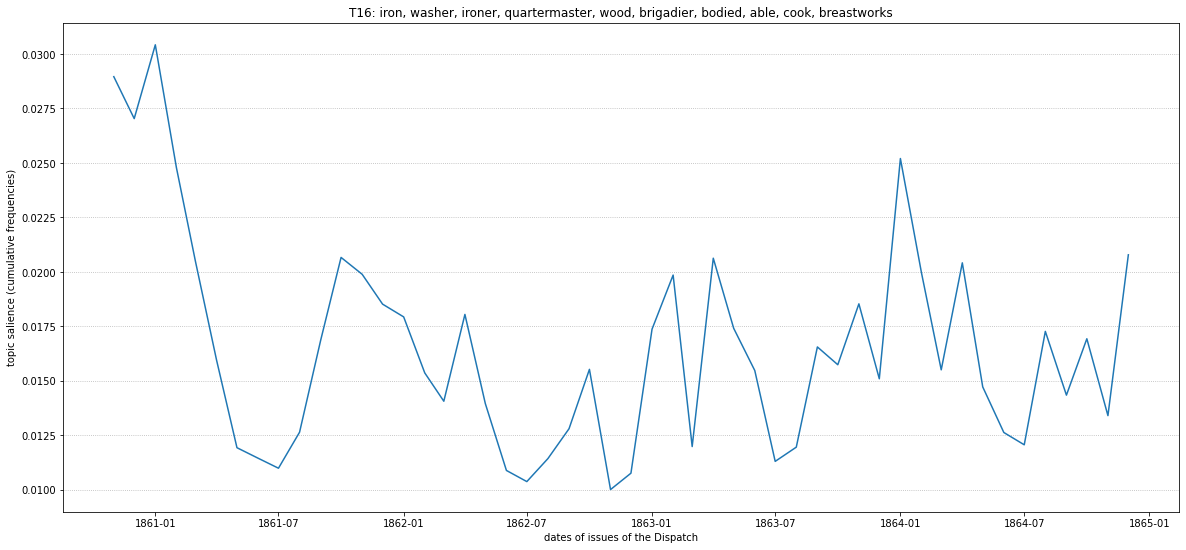

In [108]:
topic = "T16"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

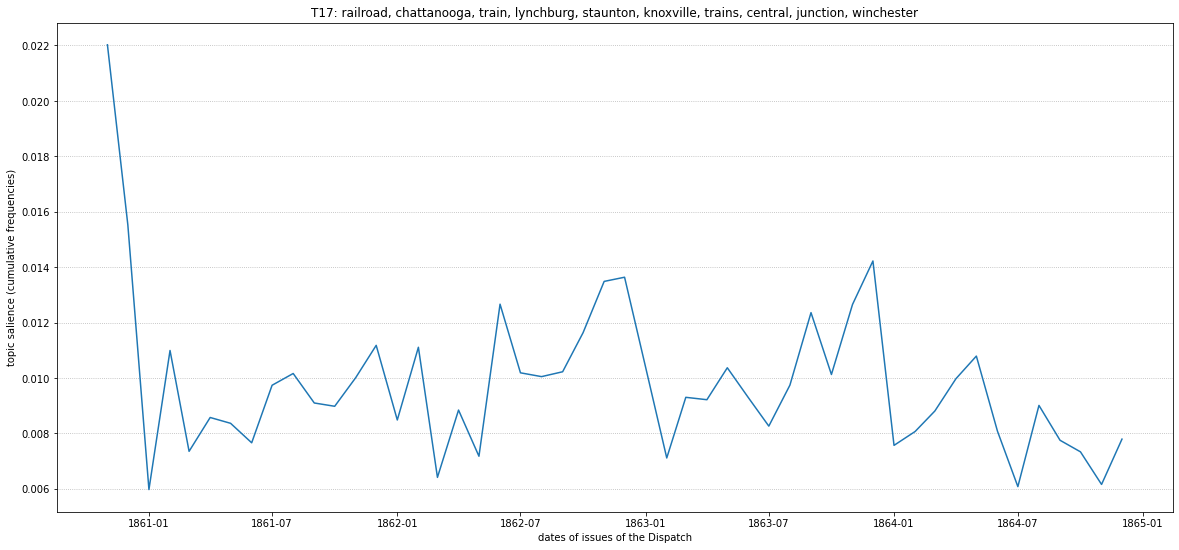

In [109]:
topic = "T17"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

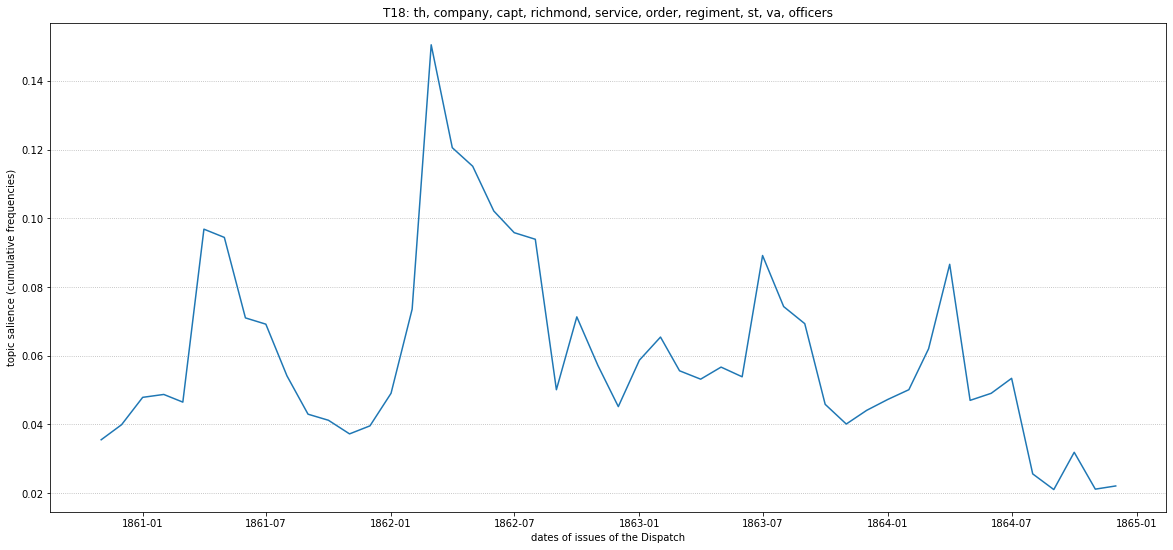

In [110]:
topic = "T18"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

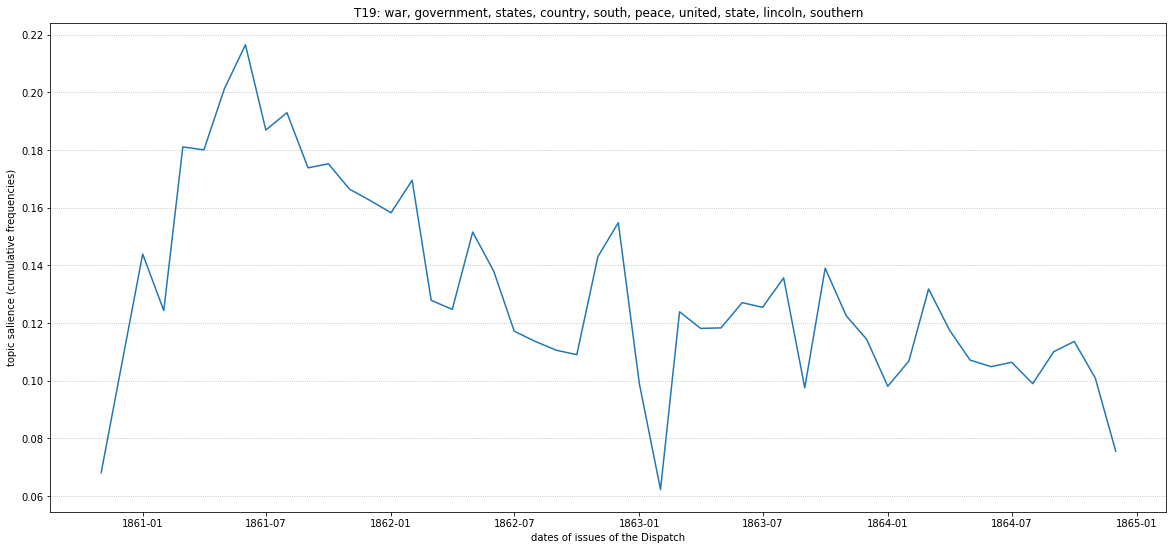

In [111]:
topic = "T19"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

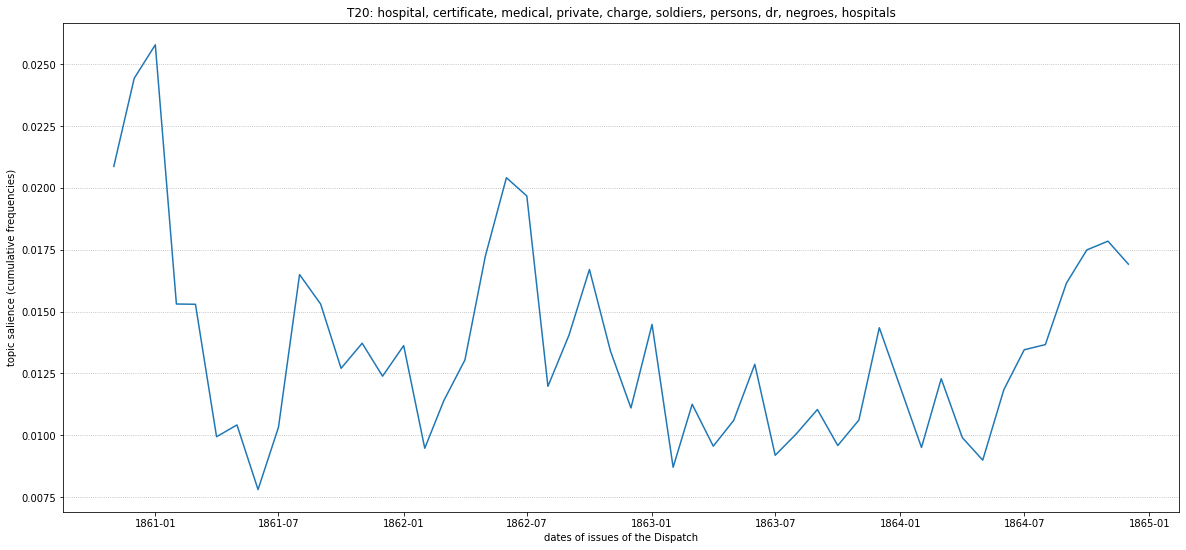

In [112]:
topic = "T20"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

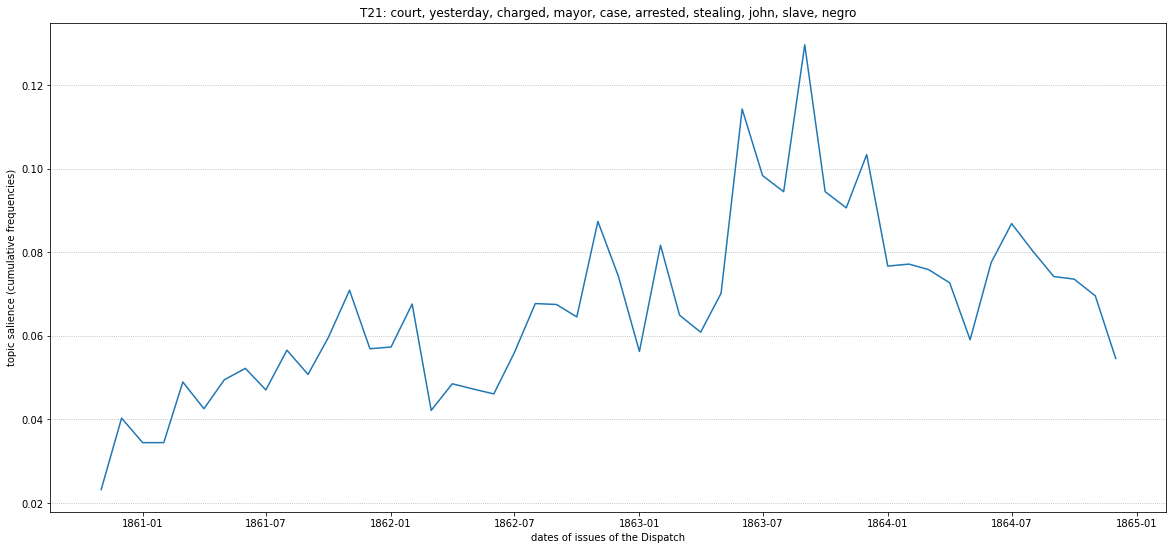

In [113]:
topic = "T21"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

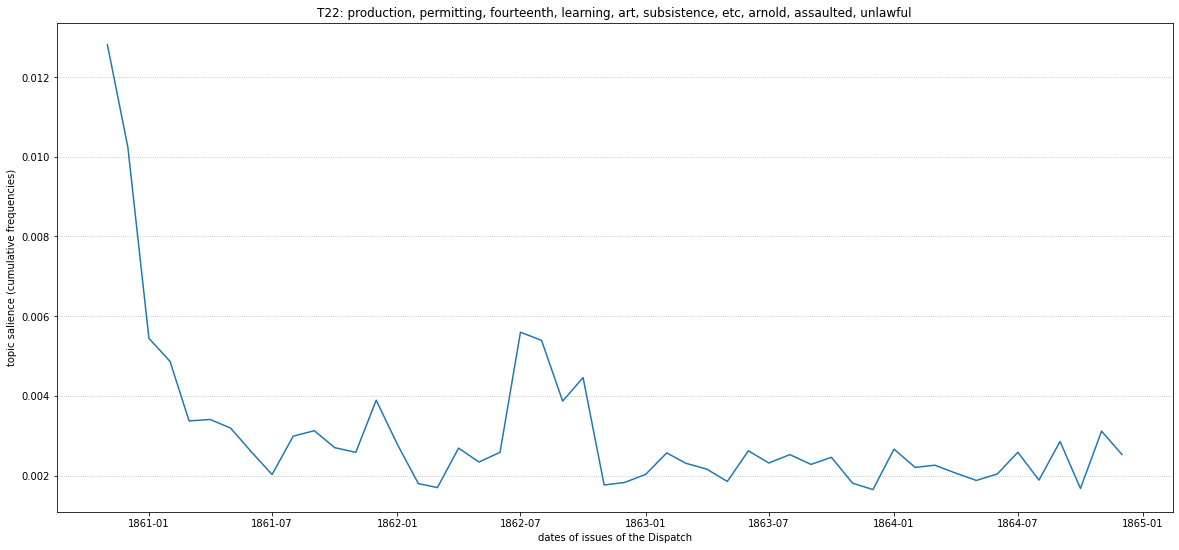

In [114]:
topic = "T22"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

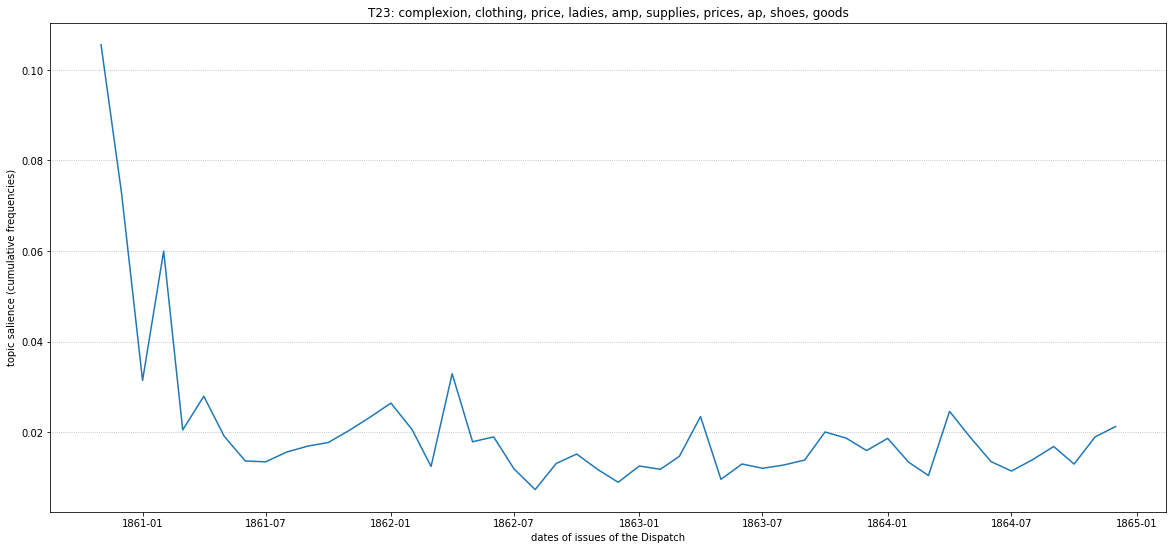

In [115]:
topic = "T23"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

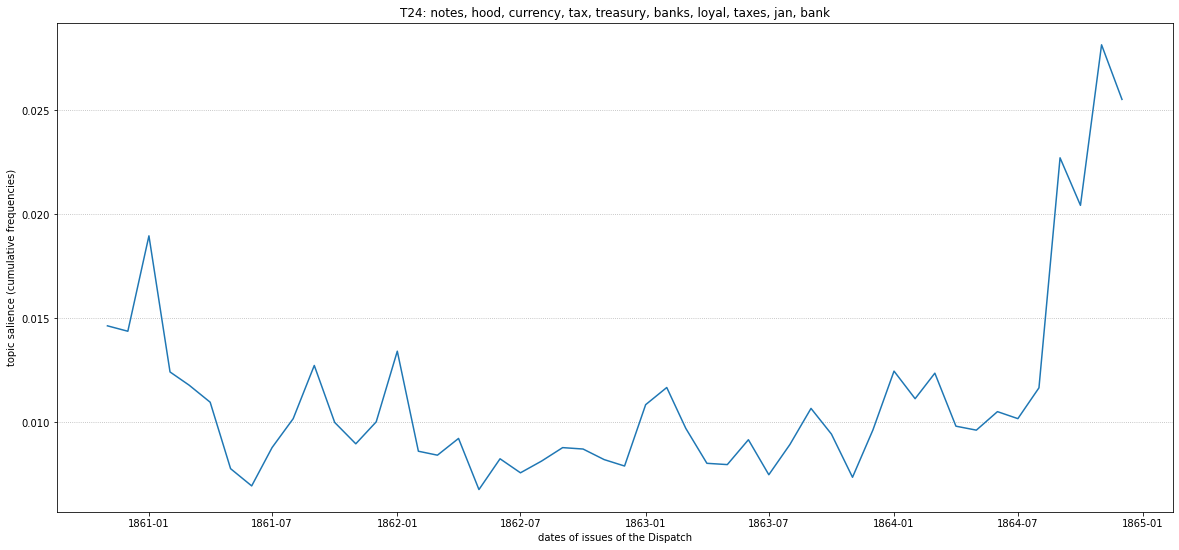

In [116]:
topic = "T24"
plt.plot(topicSum['month'], topicSum[topic])
plt.ylabel("topic salience (cumulative frequencies)")
plt.xlabel("dates of issues of the Dispatch")
plt.title(topic + ": " + topicDic[topic])
plt.gca().yaxis.grid(linestyle=':')

# Re-using our LDA model

The trained LDA model can be applied to new texts, although this, of course should be done with utmost care. In general, this works as shown below. We'll start with text already split into a list of words, converted into lower case (*original text*: "Caliph Umar led the conquest of several Iranian provinces."):

In [83]:
new_doc = ['caliph', 'umar', 'led', 'conquest', 'several', 'iranian', 'provinces']
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(lda_model.get_document_topics(new_doc_bow))

[(4429, 1), (13912, 1), (22024, 1)]
[(0, 0.3468962), (1, 0.013902348), (2, 0.013902348), (3, 0.013902348), (4, 0.013902348), (5, 0.013902348), (6, 0.013902348), (7, 0.013902348), (8, 0.013902348), (9, 0.013902348), (10, 0.013902348), (11, 0.34725213), (12, 0.013902348), (13, 0.013902348), (14, 0.013902348), (15, 0.013902348), (16, 0.013902348), (17, 0.013902348), (18, 0.013902348), (19, 0.013902348), (20, 0.013902348), (21, 0.013902348), (22, 0.013902348), (23, 0.013902348)]


The first list is the words that match words in our model. The second list is the topics and their proportions. You can check the matching words by typing `dictionary[number]` where `number` is the first number in the tuple (`(4429, 1)`). You can also check the ropics by typing `lda_model.print_topic(number)`, where the number is the number of the topic in the tuples of the second liist. Try them below:

In [84]:
print(dictionary[4429], dictionary[13912], dictionary[22024])

led provinces conquest


Results for texts from the same period and region should, however, be much better. Let;s take another example (just a few lines from [here](https://www.thoughtco.com/the-battle-of-antietam-1773739)):

> After a summer of defeats in Virginia in the summer of 1862, the Union Army was demoralized in its camps near Washington, D.C. at the beginning of September. On the Confederate side, General Robert E. Lee was hoping to strike a decisive blow by invading the North. Lee's plan was to strike into Pennsylvania, imperiling the city of Washington and forcing an end to the war. The Confederate Army began crossing the Potomac on September 4, and within a few days had entered Frederick, a town in western Maryland. The citizens of the town stared at the Confederates as they passed through, hardly extending the warm welcome Lee had hoped to receive in Maryland. Lee split up his forces, sending part of the Army of Northern Virginia to capture the town of Harpers Ferry and its federal arsenal (which had been the site of John Brown's raid three years earlier).

In [85]:
testDoc = ["after", "a", "summer", "of", "defeats", "in", "virginia", "in", "the", "summer",
           "of", "1862", "the", "union", "army", "was", "demoralized", "in", "its", "camps",
           "near", "washington", "d", "c", "at", "the", "beginning", "of", "september", "on",
           "the", "confederate", "side", "general", "robert", "e", "lee", "was", "hoping",
           "to", "strike", "a", "decisive", "blow", "by", "invading", "the", "north", "lee",
           "s", "plan", "was", "to", "strike", "into", "pennsylvania", "imperiling", "the",
           "city", "of", "washington", "and", "forcing", "an", "end", "to", "the", "war",
           "the", "confederate", "army", "began", "crossing", "the", "potomac", "on", "september",
           "4", "and", "within", "a", "few", "days", "had", "entered", "frederick", "a", "town",
           "in", "western", "maryland", "the", "citizens", "of", "the", "town", "stared", "at",
           "the", "confederates", "as", "they", "passed", "through", "hardly", "extending", "the",
           "warm", "welcome", "lee", "had", "hoped", "to", "receive", "in", "maryland", "lee",
           "split", "up", "his", "forces", "sending", "part", "of", "the", "army", "of",
           "northern", "virginia", "to", "capture", "the", "town", "of", "harpers", "ferry",
           "and", "its", "federal", "arsenal", "which", "had", "been", "the", "site", "of",
           "john", "brown", "s", "raid", "three", "years", "earlier"]

testDoc = dictionary.doc2bow(testDoc)
print(testDoc)
print("=====")
print(lda_model.get_document_topics(testDoc))

[(33, 1), (68, 1), (69, 2), (158, 1), (221, 1), (222, 1), (338, 1), (373, 1), (395, 1), (419, 1), (544, 2), (633, 1), (738, 1), (869, 1), (880, 2), (1066, 2), (1081, 2), (1121, 3), (1134, 1), (1296, 2), (1466, 1), (1555, 1), (1665, 1), (1710, 1), (1721, 1), (1750, 4), (1779, 1), (1804, 1), (1826, 1), (2013, 1), (2145, 1), (2942, 3), (2976, 1), (3674, 1), (3858, 1), (3892, 1), (4228, 1), (5335, 1), (5772, 1), (7281, 1), (7632, 1), (7748, 1), (7912, 1), (8175, 1), (8901, 1), (9440, 1), (9716, 2), (9743, 1), (9754, 1), (9842, 1), (11635, 1), (12674, 1), (14511, 1), (19433, 1), (19731, 1), (21168, 1), (24856, 1), (62883, 1)]
=====
[(1, 0.6709197), (3, 0.03335574), (7, 0.03508139), (11, 0.07074983), (18, 0.16122122), (19, 0.017632391)]


What is the dominant topics? Try your code below: